# Project Summary

The goal of the is to build a data pipline around newspaper article data, include some non-trivial ML based functionality in python.
I decided to do sentiment analysis and thereby predict the sentiment of newspaper articles.

To train a sentiment classification I need labeled training data. As I want to predict the sentiment of german newspaper articles, I need german text.
The only good labeled dataset that I found was from Oliver Guhr ("https://github.com/oliverguhr/german-sentiment"). But as we should practice data scraping during this project I couldn't just load the preprocessed data. That is why I decided to pick the movie review website "filmstarts.de" and scrape movie ratings. Based on the rating of a movie, I then classify the text as positive or negative sentiment. Therefore, I get labeled text data. Unfortunately filmstarts has no api where you can easily fetch the data from. Also, I couldn't find a python package or code from github which already solved fetching tasks from filmstarts. That was quite a bummer, thus I had to create my own scraping using beautifulsoup4.

Fortunately, the website of "filmstarts.de" is good structured. In the base url "https://www.filmstarts.de/kritiken/neuste-kritiken/" all the latest reviews are added. The website also implemented pagination in the url query parameters as "?page=123". Thereby I can easily loop over the pages. In each page I had to extract the movie IDs. That was also easily solved, as all the movie IDs are links with a specific class (class_="meta-title-link"). After getting the movie IDs I could directly jump to the full review page and skip one "click" by accessing the url via "https://www.filmstarts.de/kritiken/neuste-kritiken/MOVIE_ID/kritik.html".
 Now I had to parse the actual review text. That was more complicated than I thought. The review text is not in one paragraph, it is seperated in all different kinds of html tags, has pictures in between blocks and advertisements as well. That is why I had to create an allow_list of html tags (['p', 'div', 'a', 'i', 'strong']) and block_class_list for html classes to only get the relevant data.
Next I scraped also the name of the movie as well as the review score. Last, I cleaned the text by removing punctuation chars and other special chars like new lines.

As the final data structure, I created a dictionary including the following elements, and saved the scraped movies as csv, as the scraping took 3 hours.
* name
* rating
* words
* characters
* text

In [ ]:
from bs4 import BeautifulSoup, NavigableString, Tag
import requests
import pandas as pd

url_base = 'https://www.filmstarts.de'
url_reviews = 'https://www.filmstarts.de/kritiken/neuste-kritiken/'


def set_to_review_url(movie_url):
    return url_base + movie_url[:-5] + '/kritik.html'


def parse_review_text(review_elements):
    text_elements = []
    allowlist = ['p', 'div', 'a', 'i', 'strong']
    block_class_list = ['video-card-player', 'article-figure-holder']
    for element in review_elements:
        if isinstance(element, NavigableString):
            text_elements.append(element.text)
        elif isinstance(element, Tag):
            if element.has_attr('class') and element['class'][0] not in block_class_list:
                text_elements.append(element.text)
            if not element.has_attr('class'):
                text_elements.append(element.text)
    return ''.join(text_elements).replace(u'\xa0', u' ').replace(u'\n', u'').strip()


def get_movies_in_page(page_url, modify_url_function):
    movie_urls = []
    page = requests.get(page_url)
    soup = BeautifulSoup(page.text, 'html.parser')
    movies = soup.find_all("a", class_="meta-title-link", href=True)
    for movie in movies:
        movie_urls.append(modify_url_function(movie['href']))
    return movie_urls


def extract_review_information(review_url, parse_review_text):
    review = requests.get(review_url)
    soup = BeautifulSoup(review.text, 'html.parser')
    rating = soup.find("span", class_="note").getText()
    name = soup.find("div", class_="title").getText()
    text = parse_review_text(soup.find("div", class_="editorial-content cf"))
    cleaned_text = remove_punctuation(text)
    return {'name': name.replace(u'\n', u'').strip(),
            'rating': float(rating.replace(',', '.')),
            'words': len(cleaned_text.split()),
            'characters': len(cleaned_text),
            'text': cleaned_text}


def get_page_url(page_number):
    return 'https://www.filmstarts.de/kritiken/neuste-kritiken/?page=' + str(page_number)


def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":", "!", '"', '„', '“', '(', ')', ',', '–'))
    return final


# currently page 1-722 available
last_page = 722
scraped_movies = []
for page in range(1, last_page + 1):
    try:
        print('current processed page: ' + str(page))
        movie_list_in_page = get_movies_in_page(get_page_url(page), set_to_review_url)
        for movie in movie_list_in_page:
            try:
                scraped_movies.append(extract_review_information(movie, parse_review_text))
                # checkpoints
                if len(scraped_movies) % 100 == 0:
                    pd.DataFrame(scraped_movies).to_csv('scraped_movies.csv', encoding='utf-8-sig')
            except:
                print('movie error')
                pass
    except:
        print('page error')
        pass
    # final save
pd.DataFrame(scraped_movies).to_csv('scraped_movies.csv', encoding='utf-8-sig')

current processed page: 1
current processed page: 2
movie error
current processed page: 3
current processed page: 4
movie error
current processed page: 5
movie error
current processed page: 6
current processed page: 7
current processed page: 8
current processed page: 9
current processed page: 10
current processed page: 11
current processed page: 12
current processed page: 13
current processed page: 14
current processed page: 15
current processed page: 16
current processed page: 17
current processed page: 18
current processed page: 19
current processed page: 20
current processed page: 21
current processed page: 22
current processed page: 23
movie error
movie error
movie error
current processed page: 24


Next I also scraped the newspaper articles with the given code from the lecture. I added the same cleaning steps as I did in my own movie review scraping and also added the "words" and "characters" in the article information.

In [4]:
import newspaper
import pandas as pd

news_websites = ['https://welt.de']  #'https://www.spiegel.de/']  #,
scraped_articles = []

counter = 1
for news_website in news_websites:
    news = newspaper.build(news_website)
    for article in news.articles:
        try:
            article.download()
            article.parse()
            cleaned_text = remove_punctuation(article.text)
            scraped_articles.append({
                'newspaper': news_website,
                'url': article.url,
                'title': article.title,
                'words': len(cleaned_text.split()),
                'characters': len(cleaned_text),
                'text': cleaned_text
            })
            print("article downloaded count: " + str(counter))
            counter += 1
            # checkpoint
            if len(scraped_articles) % 100 == 0:
                pd.DataFrame(scraped_articles).to_csv('scraped_articles.csv', encoding='utf-8-sig')
        except:
            #print('you better check this error')
            pass
# final save
pd.DataFrame(scraped_articles).to_csv('scraped_articles.csv', encoding='utf-8-sig')

1
article downloaded
2
article downloaded
3
article downloaded
4
article downloaded
5
article downloaded
6
article downloaded
7
article downloaded
8
article downloaded
9
article downloaded
10


[{'newspaper': 'https://welt.de',
  'url': 'https://welt.de/politik/deutschland/plus239804539/Epidemische-Lage-Scheinlegitimation-viel-Alarmismus-und-Verwirrung.html',
  'authors': ['Ricarda Breyton',
   'Kaja Klapsa',
   'Tim Röhn',
   'Dagmar Rosenfeld',
   'Frédéric Schwilden'],
  'data': None,
  'title': 'Epidemische Lage: „Scheinlegitimation, viel Alarmismus und Verwirrung“',
  'text': 'An dieser Stelle finden Sie Inhalte aus Twitter\n\nUm eingebettete Inhalte anzuzeigen, ist deine widerrufliche Einwilligung in die Übermittlung und Verarbeitung von personenbezogenen Daten notwendig, da die Anbieter der eingebetteten Inhalte als Drittanbieter diese Einwilligung verlangen [In diesem Zusammenhang können auch Nutzungsprofile (u.a. auf Basis von Cookie-IDs) gebildet und angereichert werden, auch außerhalb des EWR]. Indem du den Schalter auf „an“ stellst, stimmst du diesen (jederzeit widerruflich) zu. Dies umfasst auch deine Einwilligung in die Übermittlung bestimmter personenbezogener 

## Data Analyzing

* take a look at the missing values

* pandas
* datawig
* sklearn - random forest, KNN
* hashing vector for words



Feel free to use fancier latent variable models, like variational bayesian topic models

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

color = sns.color_palette()
% matplotlib inline
import plotly.offline as py

py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

In [5]:

fig = px.histogram(reviews, x="rating")
fig.update_traces(marker_color="turquoise", marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Product Score')
fig.show()

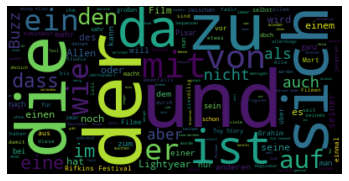

In [6]:
df_reviews = pd.DataFrame(reviews)

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Create stopword list:
#stopwords = set(STOPWORDS)
#nltk.download('stopwords')

#stopwords.update(["br", "href"])
textt = " ".join(review for review in df_reviews.text)
wordcloud = WordCloud().generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

In [7]:
df_reviews.head()

,rating,sentiment,movie,text
0,4.5,positive,Animals - Wie wilde Tiere,Sas ursprünglich aus akademischen Fächern wie ...
1,1.5,negative,Rifkin's Festival,Mort Rifkin (Wallace Shawn) hat einmal ein Fil...
2,3.0,neutral,Lightyear,Obwohl sich das Animations-Abenteuer „A Toy St...


In [8]:
#df_reviews = df_reviews[df_reviews['rating'] != 3]
df_reviews['sentimentauto'] = df_reviews['rating'].apply(lambda rating: +1 if rating > 3 else 0)

In [9]:
# split df - positive and negative sentiment:
positive = df_reviews[df_reviews['sentimentauto'] == 1]
negative = df_reviews[df_reviews['sentimentauto'] == 0]

In [32]:
todo

NameError: name 'todo' is not defined

In [10]:
df_reviews.head()

,rating,sentiment,movie,text,sentimentauto
0,4.5,positive,Animals - Wie wilde Tiere,Sas ursprünglich aus akademischen Fächern wie ...,1
1,1.5,negative,Rifkin's Festival,Mort Rifkin (Wallace Shawn) hat einmal ein Fil...,0
2,3.0,neutral,Lightyear,Obwohl sich das Animations-Abenteuer „A Toy St...,0


In [11]:
df_reviews.loc[df_reviews['sentimentauto'] == 0, 'sentimentt'] = 'negative'
df_reviews.loc[df_reviews['sentimentauto'] == 1, 'sentimentt'] = 'positive'
fig = px.histogram(df_reviews, x="sentimentt")
fig.update_traces(marker_color="indianred", marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Product Sentiment')
fig.show()

In [12]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":", "!", '"'))
    return final


df_reviews['text'] = df_reviews['text'].apply(remove_punctuation)


In [13]:
dfNew = df_reviews[['text', 'sentimentt']]
dfNew.head()

,text,sentimentt
0,Sas ursprünglich aus akademischen Fächern wie ...,positive
1,Mort Rifkin (Wallace Shawn) hat einmal ein Fil...,negative
2,Obwohl sich das Animations-Abenteuer „A Toy St...,negative


In [51]:
import numpy as np

# random split train and test data
index = dfNew.index
dfNew['random_number'] = np.random.randn(len(index))
train = dfNew[dfNew['random_number'] <= 0.8]
test = dfNew[dfNew['random_number'] > 0.8]

C:\Users\henninta\AppData\Local\Temp\ipykernel_13764\3263563703.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [53]:
train.head()
test.head()

,text,sentimentt,random_number
1,Mort Rifkin (Wallace Shawn) hat einmal ein Fil...,negative,1.250696


In [55]:
# count vectorizer:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train['text'])
test_matrix = vectorizer.transform(test['text'])

In [56]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [71]:
X_train = train_matrix
X_test = test_matrix
y_train = train['sentimentt']
y_test = test['sentimentt']

In [72]:
X_train = train_matrix
X_test = test_matrix
y_train = train['sentimentt']
y_test = test['sentimentt']
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

In [59]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix, classification_report

new = np.asarray(y_test)
confusion_matrix(predictions, y_test)
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       0.0
    positive       0.00      0.00      0.00       1.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



C:\pythonenvs\Exam2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\pythonenvs\Exam2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\pythonenvs\Exam2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\pythonenvs\Exam2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Lasso, SGDRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import HashingVectorizer

sentiment_classifier = Pipeline([('vect', HashingVectorizer(n_features=int(2 ** 15))),  #TfidfVectorizer()),#
                                 ('clas', RandomForestClassifier())])

# perform gridsearch to get the best regularizer
#X = df_reden['rede']
#y = df_reden[[c for c in df_reden.columns if 'Beifall' in c]]

#cv_score_applause_reg = cross_val_score(applause_regressor, X, y, error_score=mean_absolute_error)
#print(f'CV Score Applause: {cv_score_applause_reg}')
##


X_train = dfNew['text']
y_train = dfNew['sentimentt']

sentiment_classifier.fit(X_train, y_train)
# overfitted, but it's just a sanity check
print(sentiment_classifier.predict(X_train))
#(y_train - sentiment_classifier.predict(X_train)).abs().mean()


sentiment_predictions = sentiment_classifier.predict(df['text'])
print(sentiment_predictions)
#for p, applause in zip(parties, sentiment_predictions.T):
#    df[f'applause_predicted-{p}'] = applause
#df.sort_values(by='applause_predicted-CDU/CSU').head()

['positive' 'negative' 'negative']
['negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative']


In [20]:
dfNew = df_reviews[['text', 'sentimentauto']]
dfNew.head()

,text,sentimentauto
0,Sas ursprünglich aus akademischen Fächern wie ...,1
1,Mort Rifkin (Wallace Shawn) hat einmal ein Fil...,0
2,Obwohl sich das Animations-Abenteuer „A Toy St...,0


# Autogluon

Next I also wanted to try out Autogluon. The textpredictor in the latest version 0.5.0 was not working for me, that is why I installed the prior version 0.4.0.

For supervised learning with text data, AutoGluon provides a simple fit() function that automatically produces high quality text prediction models (Transformer neural networks). Each training example may be a sentence, a short paragraph, comprised of multiple text fields (e.g. predicting how similar two sentences are), or may even contain additional numeric/categorical features beyond just text. The target values (labels) to predict may be continuous values (regression) or discrete categories (classification). A single call to predictor.fit() will train highly accurate neural networks on your provided text dataset, automatically leveraging accuracy-boosting techniques such as fine-tuning a pretrained NLP model (transfer learning) and hyperparameter optimization.

In [21]:
from sklearn.model_selection import train_test_split  #splitting the dataset
#from autogluon.tabular import TabularDataset, TabularPredictor #to handle tabular data and train models
from autogluon.text import TextPredictor

predictor = TextPredictor(label='sentimentauto').fit(train_data=dfNew,
                                                     time_limit=60)  #presets='best_quality')  verbosity = 2,
#predictor.fit_summary()
#predictor.leaderboard(dfNew, silent=True)
#predictor.feature_importance(data=dfNew)
#y_pred = predictor.predict(test_data)
#y_pred=pd.DataFrame(y_pred,columns=['stroke'])
#y_pred #print the DataFrame
#predictor.evaluate(df_test)

Global seed set to 123
C:\pythonenvs\Exam2\lib\site-packages\autogluon\text\automm\data\infer_types.py:253: UserWarning:

Label column "sentimentauto" contains only one label. You may want to check your dataset again.

C:\pythonenvs\Exam2\lib\site-packages\autogluon\text\automm\predictor.py:493: UserWarning:

Only CPU is detected in the instance. AutoMMPredictor will be trained with CPU only. This may results in slow training speed. Consider to switch to an instance with GPU support.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name              | Type                         | Params
-------------------------------------------------------------------
0 | model             | HFAutoModelForTextPrediction | 108 M 
1 | validation_metric | MeanSquaredError             | 0     
2 | loss_func         | MSELoss                      | 0     
-------------------------------------------------------------------
108 M     Trai

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 123
C:\pythonenvs\Exam2\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning:

The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 0: val_rmse reached 3.71822 (best 3.71822), saving model to "C:\Users\henninta\OneDrive - Boehringer Ingelheim\Documents\DS_Studium\2_Semester\Workflow\Exam2\AutogluonModels\ag-20220708_203209\epoch=0-step=0.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 1: val_rmse reached 3.71822 (best 3.71822), saving model to "C:\Users\henninta\OneDrive - Boehringer Ingelheim\Documents\DS_Studium\2_Semester\Workflow\Exam2\AutogluonModels\ag-20220708_203209\epoch=1-step=1.ckpt" as top 3
Time limit reached. Elapsed time is 0:01:03. Signaling Trainer to stop.


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 2: val_rmse reached 1.84215 (best 1.84215), saving model to "C:\Users\henninta\OneDrive - Boehringer Ingelheim\Documents\DS_Studium\2_Semester\Workflow\Exam2\AutogluonModels\ag-20220708_203209\epoch=2-step=2.ckpt" as top 3
Saving latest checkpoint...


In [22]:
predictor.fit_summary()

AttributeError: 'TextPredictor' object has no attribute 'fit_summary'

In [17]:
from importlib.metadata import version

version('autogluon')

'0.4.0'

In [18]:
dfNew.head()

,text,sentimentt
0,Sas ursprünglich aus akademischen Fächern wie ...,positive
1,Mort Rifkin (Wallace Shawn) hat einmal ein Fil...,negative
2,Obwohl sich das Animations-Abenteuer „A Toy St...,negative


### second try without training


In [ ]:
import nest_asyncio

nest_asyncio.apply()
import twint

c = twint.Config()
c.Search = ['#jamescharles']
c.Limit = 50000
c.Store_csv = True
c.Since = '2019-01-01'
c.Output = "jamescharles.csv"
twint.run.Search(c)

In [ ]:
import pandas as pd

df = pd.read_csv('jamescharles.csv')

In [ ]:
df.info()

In [ ]:
df['tweet'][10]

In [ ]:
import nltk

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
import re
import pandas as pd
import nltk

nltk.download('words')
words = set(nltk.corpus.words.words())

In [ ]:
sentence = df['tweet'][0]
sid.polarity_scores(sentence)['compound']

In [ ]:
def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+", "", tweet)  #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet)  #Remove http links
    tweet = " ".join(tweet.split())
    tweet = tweet.replace("#", "").replace("_", " ")  #Remove hashtag sign but keep the text
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet)
                     if w.lower() in words or not w.isalpha())
    return tweet


df['tweet_clean'] = df['tweet'].apply(cleaner)

In [ ]:
word_dict = {'manipulate': -1, 'manipulative': -1, 'jamescharlesiscancelled': -1, 'jamescharlesisoverparty': -1,
             'pedophile': -1, 'pedo': -1, 'cancel': -1, 'cancelled': -1, 'cancel culture': 0.4, 'teamtati': -1,
             'teamjames': 1,
             'teamjamescharles': 1, 'liar': -1}
import nltk

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
sid.lexicon.update(word_dict)
list1 = []
for i in df['tweet_clean']:
    list1.append((sid.polarity_scores(str(i)))['compound'])

In [ ]:
df['sentiment'] = pd.Series(list1)


def sentiment_category(sentiment):
    label = ''
    if (sentiment > 0):
        label = 'positive'
    elif (sentiment == 0):
        label = 'neutral'
    else:
        label = 'negative'
    return (label)


df['sentiment_category'] = df['sentiment'].apply(sentiment_category)

In [ ]:
df = df[['tweet', 'date', 'id', 'sentiment', 'sentiment_category']]
df.head()

In [ ]:
neg = df[df['sentiment_category'] == 'negative']
neg = neg.groupby(['date'], as_index=False).count()
pos = df[df['sentiment_category'] == 'positive']
pos = pos.groupby(['date'], as_index=False).count()
pos = pos[['date', 'id']]
neg = neg[['date', 'id']]

In [ ]:
import plotly.graph_objs as go

fig = go.Figure()
for col in pos.columns:
    fig.add_trace(go.Scatter(x=pos['date'], y=pos['id'],
                             name=col,
                             mode='markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True,
                             line_color='green'
                             )
                  )
for col in neg.columns:
    fig.add_trace(go.Scatter(x=neg['date'], y=neg['id'],
                             name=col,
                             mode='markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True,
                             line_color='red'
                             )
                  )
fig.show()

In [ ]:
# filter the df to only capture Tweets from the start of May to end of June
newdf = df[(df['date'] >= '2019-05-01') & (df['date'] <= '2019-06-29')]
neg = newdf[newdf['sentiment_category'] == 'negative']
neg = neg.groupby(['date'], as_index=False).count()
pos = newdf[newdf['sentiment_category'] == 'positive']
pos = pos.groupby(['date'], as_index=False).count()
pos = pos[['date', 'id']]
neg = neg[['date', 'id']]

In [ ]:
import plotly.graph_objs as go

fig = go.Figure()
for col in pos.columns:
    fig.add_trace(go.Scatter(x=pos['date'], y=pos['id'],
                             name=col,
                             mode='markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True,
                             line_color='green'
                             )
                  )
for col in neg.columns:
    fig.add_trace(go.Scatter(x=neg['date'], y=neg['id'],
                             name=col,
                             mode='markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True,
                             line_color='red'
                             )
                  )
fig.show()

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

df2 = df[(df['date'] >= '2019-05-11') & (df['date'] <= '2019-05-14')]
positive = df2[df2['sentiment_category'] == 'positive']
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(str(positive['tweet_clean']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
neg = df[df['sentiment_category'] == 'negative']
neg = neg.groupby(['date'], as_index=False).count()
pos = df[df['sentiment_category'] == 'positive']
pos = pos.groupby(['date'], as_index=False).count()
pos = pos[['date', 'id']]
neg = neg[['date', 'id']]